TFF Modelling + Hedging Simulation 

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from statsmodels.tsa.stattools import adfuller, kpss 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error



TTF Data Loading

In [59]:
#TTF & German Day Ahead 55% ARA Coal dark sprad L2 years were pulled form ARGUS 
ttf = pd.read_excel(
    io='/Users/vid/Desktop/Commodity/Energy Markets /TTF_day_ahead_L3.xlsx',
    header=1,
    index_col=0,
    parse_dates=True 
    )

german_spread = pd.read_excel(
    io='/Users/vid/Desktop/Commodity/Energy Markets /Argus Historical Prices (2).xlsx',
    header=1,
    index_col=0,
    parse_dates=True 
    )

#Check TTF
print(ttf.head(3), ttf.tail(3))

#Check German Spread 
print(german_spread.head(3), german_spread.tail(3) )


               Timing  Price Low    Price  Price High  Change  % Change
Date                                                                   
2025-05-28  day-ahead     36.259  36.3001      36.341 -0.2752     -0.75
2025-05-27  day-ahead     36.571  36.5753      36.580  0.4249      1.18
2025-05-23  day-ahead     36.036  36.1505      36.265  0.1295      0.36                Timing  Price Low    Price  Price High  Change  % Change
Date                                                                   
2023-05-31  day-ahead     25.751  25.7746      25.799  0.2004      0.78
2023-05-30  day-ahead     25.539  25.5742      25.609  1.0237      4.17
2023-05-26  day-ahead     24.500  24.5505      24.602 -0.5991     -2.38
               Timing   Price  Change  % Change
Date                                           
2025-05-28  day-ahead  -5.294 -37.018   -116.69
2025-05-27  day-ahead  31.724   9.618     43.51
2025-05-23  day-ahead  22.106  -0.537     -2.37                Timing   Price  Change  %

In [60]:
#Variables
ttf = ttf.asfreq("B").ffill(limit=1).dropna()
german_spread = german_spread.asfreq("B").ffill(limit=1).dropna()

price_ttf = ttf["Price"]
price_spread = german_spread["Price"]


#Rolling Mean & STD
ttf["r_mean"] = ttf["Price"].rolling(window=30, min_periods=1).mean()
ttf["r_std"] = ttf["Price"].rolling(window=30, min_periods=1).std()

german_spread["r_mean"] = german_spread["Price"].rolling(window=30, min_periods=1).mean()
german_spread["r_std"] = german_spread["Price"].rolling(window=30, min_periods=1).std()

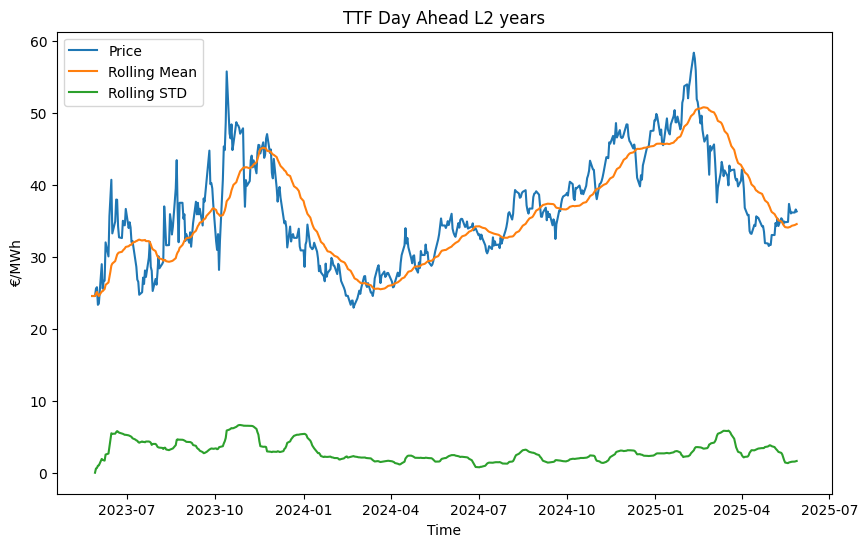

In [61]:
#TTF plot 
plt.figure(figsize=(10,6))
plt.plot(ttf["Price"], label = "Price")
plt.plot(ttf["r_mean"], label  = "Rolling Mean")
plt.plot(ttf["r_std"], label  = "Rolling STD")
plt.title("TTF Day Ahead L2 years")
plt.ylabel("€/MWh")
plt.xlabel("Time")
plt.legend()
plt.show()

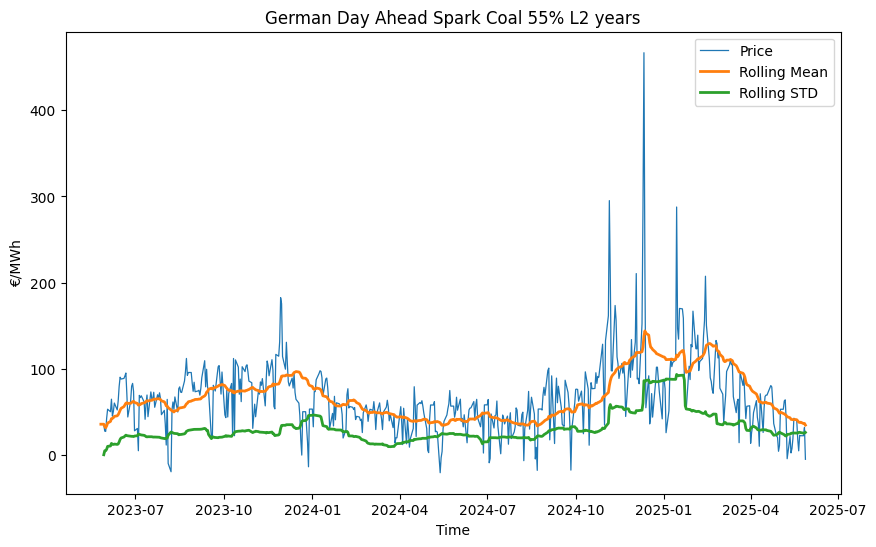

In [62]:
#Plot Dark Spread Germany DA plot 
plt.figure(figsize=(10,6))
plt.plot(german_spread["Price"], label = "Price", linewidth=0.9)
plt.plot(german_spread["r_mean"], label  = "Rolling Mean", linewidth = 2)
plt.plot(german_spread["r_std"], label  = "Rolling STD", linewidth=2)
plt.title("German Day Ahead Spark Coal 55% L2 years")
plt.ylabel("€/MWh")
plt.xlabel("Time")
plt.legend()
plt.show()


In [63]:
#ADF & KPSS for stationarity of TTF
adf_stat, adf_p, *_ = adfuller(price_ttf)
print(f"ADF Statistic: {adf_stat:.3f}")
print(f"ADF p-value:   {adf_p:.3f}\n")

kpss_stat, kpss_p, _, kpss_crit = kpss(price_ttf, regression='c')
print(f"KPSS Statistic: {kpss_stat:.3f}")
print(f"KPSS p-value:   {kpss_p:.3f}")


ADF Statistic: -2.442
ADF p-value:   0.130

KPSS Statistic: 0.962
KPSS p-value:   0.010


/var/folders/lv/ht7vykh16n7b5tj5p7ysmx9h0000gn/T/ipykernel_41380/1108659965.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, kpss_p, _, kpss_crit = kpss(price_ttf, regression='c')


In [64]:
#ADF & KPSS for stationarity of German spreads
adf_stat, adf_p, *_ = adfuller(price_spread)
print(f"ADF Statistic: {adf_stat:.3f}")
print(f"ADF p-value:   {adf_p:.3f}\n")

kpss_stat, kpss_p, _, kpss_crit = kpss(price_spread, regression='c')
print(f"KPSS Statistic: {kpss_stat:.3f}")
print(f"KPSS p-value:   {kpss_p:.3f}")

ADF Statistic: -3.528
ADF p-value:   0.007

KPSS Statistic: 0.362
KPSS p-value:   0.094


**ADF & KPSS both agree on non-stationarity for TTF -> Differencing needed (x[t] - x[t-1])**

**ADF & KPSS both agree on stationarity for German Spreads -> Differencing not needed**

In [65]:
price_differenced_ttf = price_ttf.diff().dropna()

adf_stat2, adf_p2, *_ = adfuller(price_differenced_ttf)
print(f"ADF Statistic, differenced: {adf_stat2:.3f}")
print(f"ADF p-value, differenced:   {adf_p2:.3f}\n")

kpss_stat2, kpss_p2, _, kpss_crit = kpss(price_differenced_ttf, regression='c')
print(f"KPSS Statistic, differenced: {kpss_stat2:.3f}")
print(f"KPSS p-value, differenced:   {kpss_p2:.3f}")

ADF Statistic, differenced: -10.673
ADF p-value, differenced:   0.000

KPSS Statistic, differenced: 0.061
KPSS p-value, differenced:   0.100


/var/folders/lv/ht7vykh16n7b5tj5p7ysmx9h0000gn/T/ipykernel_41380/326062400.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat2, kpss_p2, _, kpss_crit = kpss(price_differenced_ttf, regression='c')


**TTF price series is now stationary after differncing**

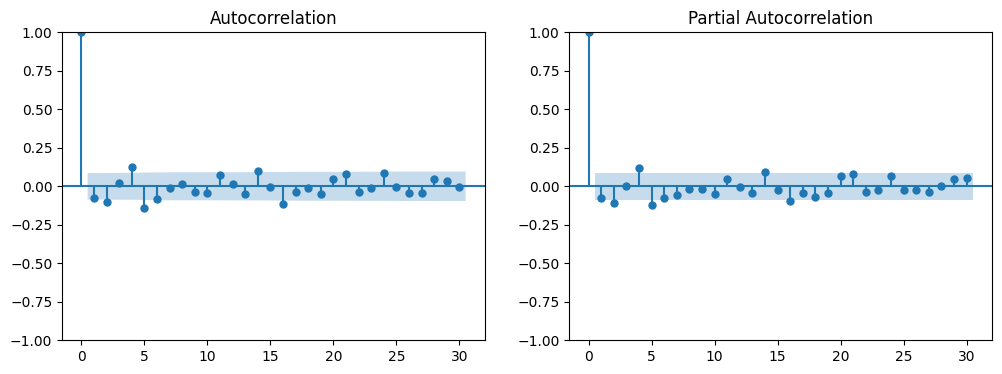

In [66]:
#TTF AC and PAC plots 
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(price_differenced_ttf, ax=axes[0], lags=30)
plot_pacf(price_differenced_ttf, ax=axes[1], lags=30, method='ywm')
plt.show()

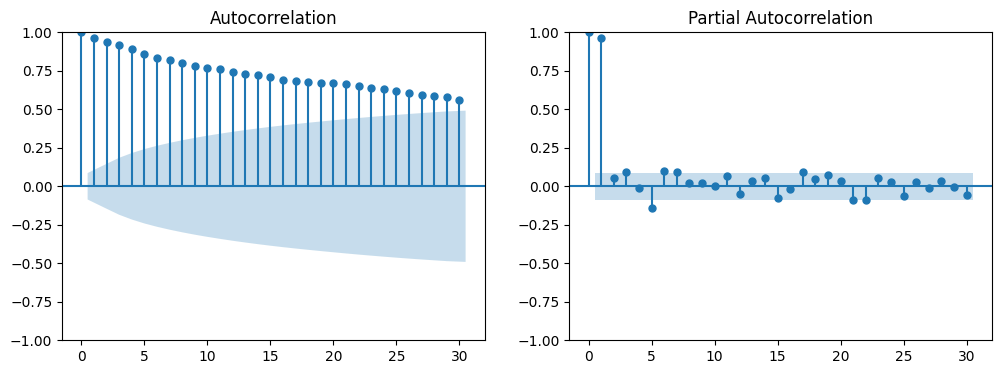

In [67]:
#TTF AC and PAC plots 
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(price_ttf, ax=axes[0], lags=30)
plot_pacf(price_ttf, ax=axes[1], lags=30, method='ywm')
plt.show()

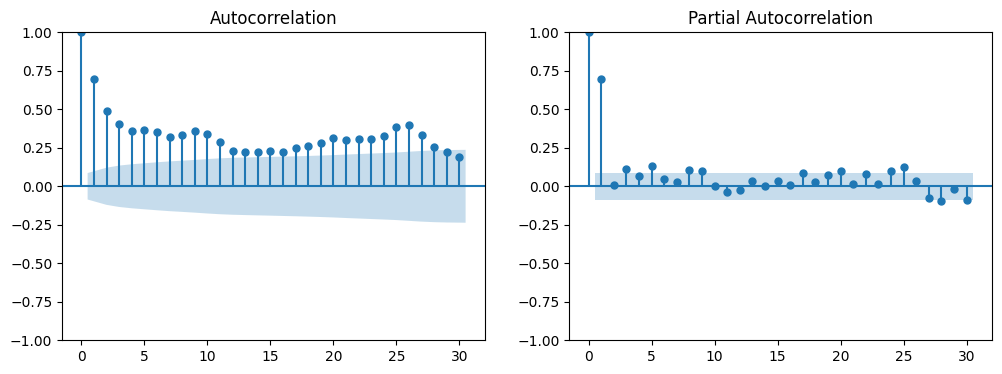

In [68]:
#German spread AC and PAC plots 
fig, axes = plt.subplots(1, 2, figsize=(12,4))
plot_acf(price_spread, ax=axes[0], lags=30)
plot_pacf(price_spread, ax=axes[1], lags=30, method='ywm')
plt.show()

In [69]:
#Fit ARIMA(1,1,1) on TTF
model_ttf = ARIMA(price_ttf, order=(1,1,1))
fit_ttf   = model_ttf.fit()

print(fit_ttf.summary())

/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  520
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1044.146
Date:                Mon, 02 Jun 2025   AIC                           2094.292
Time:                        21:34:21   BIC                           2107.048
Sample:                             0   HQIC                          2099.289
                                - 520                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8056      0.086      9.396      0.000       0.638       0.974
ma.L1         -0.8798      0.075    -11.676      0.000      -1.027      -0.732
sigma2         3.2729      0.127     25.860      0.0

**Back testing and 1-m ahead forecast**

In [70]:
#Train / Test split (80/20) + one-step forecasts TTF
train_ttf = int(len(price_ttf)*0.8)
train_ttf, test_ttf = price_ttf.iloc[:train_ttf], price_ttf.iloc[train_ttf:]

history_ttf     = train_ttf.tolist()
predictions_ttf = []

for t in range(len(test_ttf)):
    model = ARIMA(history_ttf, order=(1,1,1))
    fit   = model.fit()
    
    yhat = fit.forecast()[0]
    predictions_ttf.append(yhat)
    
    history_ttf.append(test_ttf.iloc[t])


mae  = mean_absolute_error(test_ttf, predictions_ttf)
rmse = np.sqrt(mean_squared_error(test_ttf, predictions_ttf))

print(f"Backtest TTF MAE:  {mae:.3f} €/MWh")
print(f"Backtest TTF RMSE: {rmse:.3f} €/MWh")

Backtest TTF MAE:  1.152 €/MWh
Backtest TTF RMSE: 1.491 €/MWh


In [71]:
#Train / Test split (80/20) + one-step forecasts German spreads
train_spread = int(len(price_spread)*0.8)
train_spread, test_spread = price_spread.iloc[:train_spread], price_spread.iloc[train_spread:]

history_spread = train_spread.tolist()
predictions_spread = []

for t in range(len(test_spread)):
    model = ARIMA(history_spread, order=(1,0,0))
    fit   = model.fit()
    
    yhat = fit.forecast()[0]
    predictions_spread.append(yhat)
    
    history_spread.append(test_spread.iloc[t])


mae  = mean_absolute_error(test_spread, predictions_spread)
rmse = np.sqrt(mean_squared_error(test_spread, predictions_spread))

print(f"Backtest Germany Spread MAE:  {mae:.3f} €/MWh")
print(f"Backtest Germany Sprea RMSE: {rmse:.3f} €/MWh")


Backtest Germany Spread MAE:  22.718 €/MWh
Backtest Germany Sprea RMSE: 33.207 €/MWh


/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. 

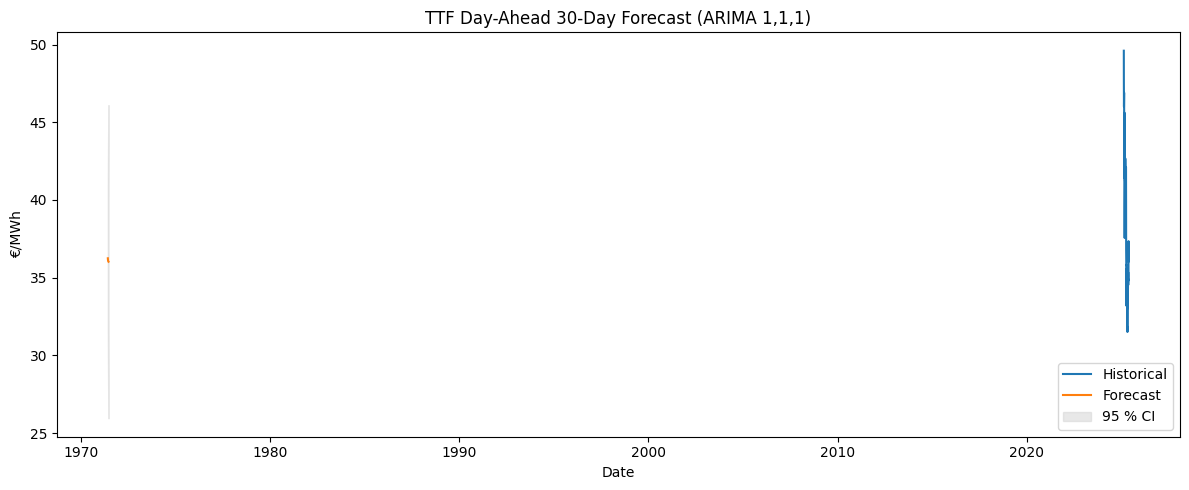

In [72]:
#Model fit on the price with business day frequency
full_fit_ttf = ARIMA(price_ttf, order=(1, 1, 1)).fit()

# 2. Produce 30-step (≈ one-month) forecast
steps_ahead = 14
ttf_res = full_fit_ttf.get_forecast(steps=14) #2-week ahead forecast

ttf_mean   = ttf_res.predicted_mean               # point forecast
ttf_bounds = ttf_res.conf_int(alpha=0.05)         # lower/upper 95 % bands

# 3. Plot: last 100 days of history + forecast
plt.figure(figsize=(12, 5))

hist_tail = price_ttf.last("100D")                  # last ~100 obs
plt.plot(hist_tail.index, hist_tail, label="Historical")

plt.plot(ttf_mean.index, ttf_mean, label="Forecast")
plt.fill_between(
    ttf_bounds.index,
    ttf_bounds.iloc[:, 0],
    ttf_bounds.iloc[:, 1],
    color="lightgrey", alpha=0.5, label="95 % CI"
)

plt.title("TTF Day-Ahead 30-Day Forecast (ARIMA 1,1,1)")
plt.ylabel("€/MWh")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vid/Desktop/Rand/Test python/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. 

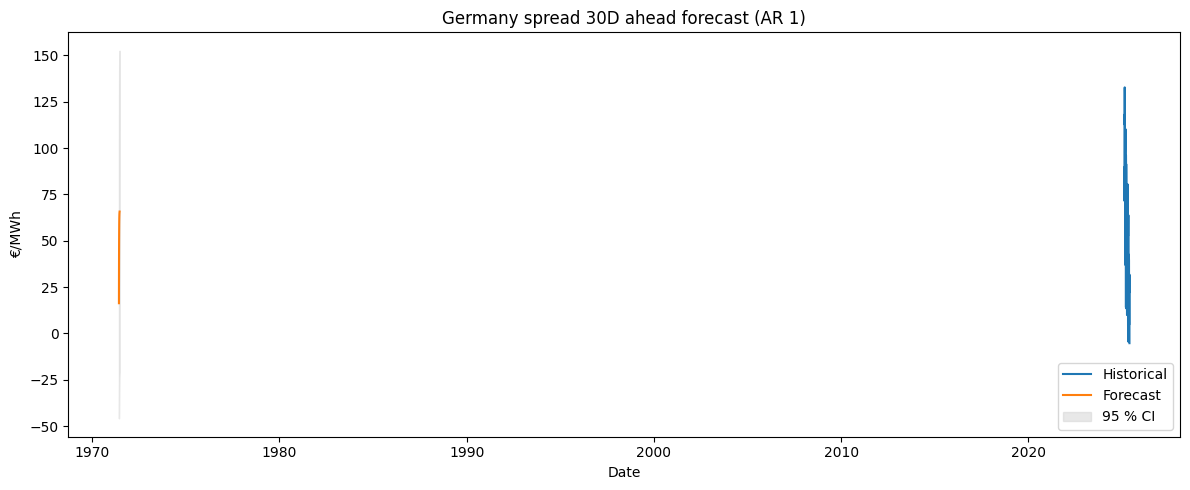

In [82]:
    #Model fit on the price with business day frequency
full_fit_spread = ARIMA(price_spread, order=(1, 0, 0)).fit()

# 2. Produce 14-step forecast
steps_ahead = 14
spread_res = full_fit_spread.get_forecast(steps=14) #2-week ahead forecast

spread_mean   = spread_res.predicted_mean               # point forecast
spread_bounds = spread_res.conf_int(alpha=0.05)         # lower/upper 95 % bands

# 3. Plot: last 100 days of history + forecast
plt.figure(figsize=(12, 5))

hist_tail = price_spread.last("100D")                  # last ~100 obs
plt.plot(hist_tail.index, hist_tail, label="Historical")

plt.plot(spread_mean.index, spread_mean, label="Forecast")
plt.fill_between(
    spread_bounds.index,
    spread_bounds.iloc[:, 0],
    spread_bounds.iloc[:, 1],
    color="lightgrey", alpha=0.5, label="95 % CI"
)

plt.title("Germany spread 30D ahead forecast (AR 1)")
plt.ylabel("€/MWh")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

**Demos using TTF & German DA spark spreads for hedging purposes**

In [74]:
#If forecasted sigma is above lowest quartile -> hedge 80%, if in the middle hedge 90%, otherwise hedge 100%
def choose_hedge_ratio(sigma_1d: float, low_th: float, high_th: float) -> float:
    if sigma_1d <= low_th:
        return 0.80
    elif sigma_1d >= high_th:
        return 1.00
    else:
        return 0.90
    

In [75]:
# TTF gas: 8 MWh/day × hedge_ratio_tt
gas_daily_mwh    = 8.0
hedge_qty_tt_mwh = gas_daily_mwh * hedge_ratio_tt

# Spark coal: plant produces 100 MWh/day → 0.412 t/MWh → 100×0.412 = 41.2 t if fully hedged
full_coal_t      = 0.412 * 100.0
if hedge_ratio_sp < 1.0:
    # Coal-only partial
    hedge_coal_t    = full_coal_t * hedge_ratio_sp
    hedge_power_mwh = 0.0
    strategy_label  = f"Coal-Only ({int(hedge_ratio_sp*100)}% of coal)"
else:
    # Full spark-lock (coal + power)
    hedge_coal_t    = full_coal_t
    hedge_power_mwh = 100.0
    strategy_label  = "Full Spark-Lock (100%)"


In [76]:
# 1) Compute 30-day rolling σ on the full TTF and Spark series
#    (price_ttf and price_spread must each be a business-day index with all historical dates)
sigma_hist_tt = price_ttf.diff().rolling(window=30).std().dropna()
sigma_hist_sp = price_spread.diff().rolling(window=30).std().dropna()

# 2) Prepare the “test split” for TTF (unchanged from your original code)
split_idx_ttf = int(len(price_ttf) * 0.8)
test_ttf      = price_ttf.iloc[split_idx_ttf :]

results = []

# 3) Loop only over the test_TTF dates
for date in test_ttf.index:
    # If we don’t yet have 30 days of rolling σ for this date (in either series), skip it
    if (date not in sigma_hist_tt.index) or (date not in sigma_hist_sp.index):
        continue

    # 3a) TTF’s realized σ and thresholds
    sigma_tt_today = sigma_hist_tt.loc[date]
    hist_sigma_tt  = sigma_hist_tt.loc[: date - pd.offsets.BDay(1)]
    low_th_tt      = hist_sigma_tt.quantile(0.25)
    high_th_tt     = hist_sigma_tt.quantile(0.75)

    if sigma_tt_today <= low_th_tt:
        hedge_ratio_tt = 0.80
    elif sigma_tt_today >= high_th_tt:
        hedge_ratio_tt = 1.00
    else:
        hedge_ratio_tt = 0.90

    # 3b) Spark’s (Spread) realized σ and thresholds
    sigma_sp_today = sigma_hist_sp.loc[date]
    hist_sigma_sp  = sigma_hist_sp.loc[: date - pd.offsets.BDay(1)]
    low_th_sp      = hist_sigma_sp.quantile(0.25)
    high_th_sp     = hist_sigma_sp.quantile(0.75)

    if sigma_sp_today <= low_th_sp:
        hedge_ratio_sp = 0.80
    elif sigma_sp_today >= high_th_sp:
        hedge_ratio_sp = 1.00
    else:
        hedge_ratio_sp = 0.90

    # 3c) Append one row for this test date
    results.append({
        "Date":               date,
        "Price_TTF":          price_ttf.loc[date],
        "Sigma_TTF":          sigma_tt_today,
        "Low_Th_TTF":         low_th_tt,
        "High_Th_TTF":        high_th_tt,
        "Hedge_Ratio_TTF":    hedge_ratio_tt,
        "Price_Spread":       price_spread.loc[date],
        "Sigma_Spread":       sigma_sp_today,
        "Low_Th_Spread":      low_th_sp,
        "High_Th_Spread":     high_th_sp,
        "Hedge_Ratio_Spread": hedge_ratio_sp
    })

# 4) Build the DataFrame and set its index to “Date”
hedging_results = pd.DataFrame(results).set_index("Date")

# 5) Quick check: Does hedging_results now only contain test dates,
#    from the first valid rolling-std date through the last test date?
print("First few hedging rows:\n", hedging_results.head(), "\n")
print("Last few hedging rows:\n", hedging_results.tail(), "\n")

# 6) Check that hedging_results.index.max() is the same as test_ttf.index.max()
print("Test split ends:", test_ttf.index.max())
print("Hedging results ends:", hedging_results.index.max())

First few hedging rows:
             Price_TTF  Sigma_TTF  Low_Th_TTF  High_Th_TTF  Hedge_Ratio_TTF  \
Date                                                                         
2025-01-02    49.8511   1.215167    0.972703     2.301669              0.9   
2025-01-03    49.4501   1.171054    0.973369     2.301220              0.9   
2025-01-06    46.9508   1.203944    0.974036     2.300772              0.9   
2025-01-07    47.6752   1.196445    0.974703     2.300323              0.9   
2025-01-08    45.8000   1.232555    0.974742     2.298555              0.9   

            Price_Spread  Sigma_Spread  Low_Th_Spread  High_Th_Spread  \
Date                                                                    
2025-01-02        76.628     80.491176      20.758781       34.350176   
2025-01-03        25.613     80.972654      20.758976       34.497266   
2025-01-06        51.038     80.718309      20.759172       34.628045   
2025-01-07        96.906     80.570261      20.759368       34.

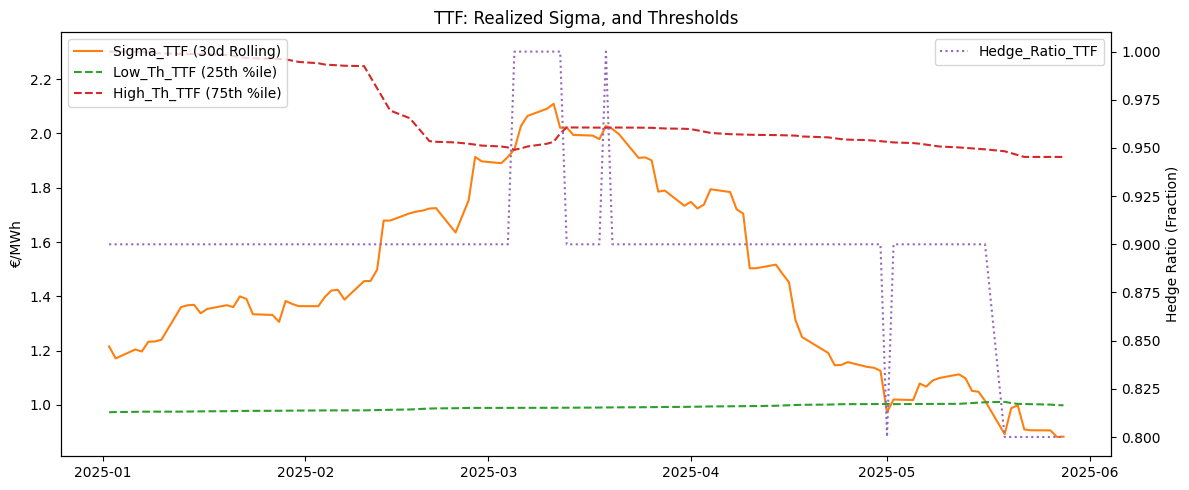

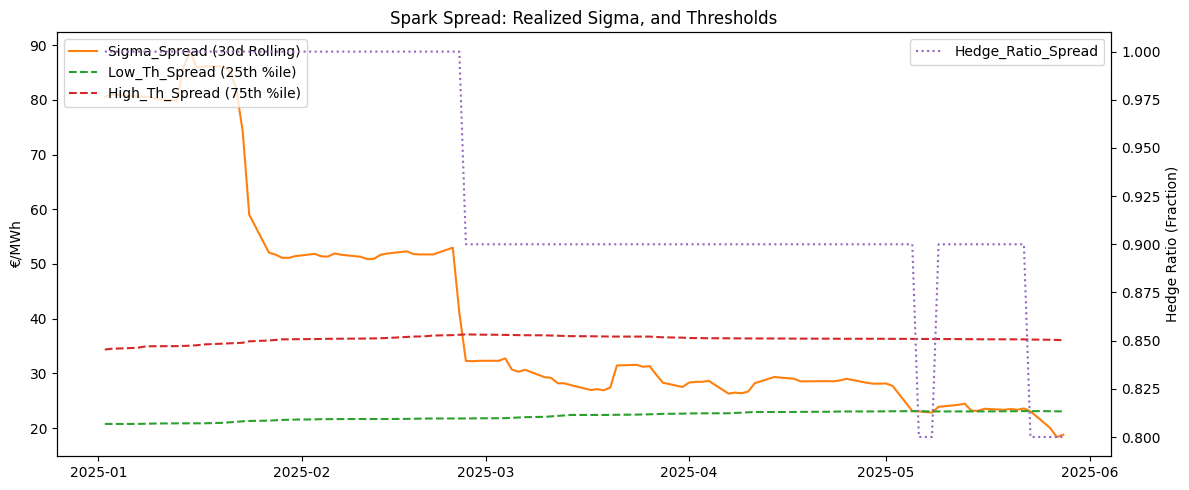

In [77]:
# Plotting TTF-related variables
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(hedging_results.index, hedging_results["Sigma_TTF"], label="Sigma_TTF (30d Rolling)", color='tab:orange')
ax1.plot(hedging_results.index, hedging_results["Low_Th_TTF"], label="Low_Th_TTF (25th %ile)", color='tab:green', linestyle='--')
ax1.plot(hedging_results.index, hedging_results["High_Th_TTF"], label="High_Th_TTF (75th %ile)", color='tab:red', linestyle='--')
ax1.set_ylabel("€/MWh")
ax1.set_title("TTF: Realized Sigma, and Thresholds")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(hedging_results.index, hedging_results["Hedge_Ratio_TTF"], label="Hedge_Ratio_TTF", color='tab:purple', linestyle=':')
ax2.set_ylabel("Hedge Ratio (Fraction)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()

# Plotting Spark-related variables
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.plot(hedging_results.index, hedging_results["Sigma_Spread"], label="Sigma_Spread (30d Rolling)", color='tab:orange')
ax1.plot(hedging_results.index, hedging_results["Low_Th_Spread"], label="Low_Th_Spread (25th %ile)", color='tab:green', linestyle='--')
ax1.plot(hedging_results.index, hedging_results["High_Th_Spread"], label="High_Th_Spread (75th %ile)", color='tab:red', linestyle='--')
ax1.set_ylabel("€/MWh")
ax1.set_title("Spark Spread: Realized Sigma, and Thresholds")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(hedging_results.index, hedging_results["Hedge_Ratio_Spread"], label="Hedge_Ratio_Spread", color='tab:purple', linestyle=':')
ax2.set_ylabel("Hedge Ratio (Fraction)")
ax2.legend(loc="upper right")

plt.tight_layout()
plt.show()


In [78]:
# What’s the earliest date in sigma_hist_sp (i.e. first day with 30‐day history)?
print("First date with a valid 30‐day rolling σ for Spark:", sigma_hist_sp.index.min())

# What’s the last date in sigma_hist_sp?
print("Last date with a valid 30‐day rolling σ for Spark:", sigma_hist_sp.index.max())


First date with a valid 30‐day rolling σ for Spark: 2023-07-07 00:00:00
Last date with a valid 30‐day rolling σ for Spark: 2025-05-28 00:00:00


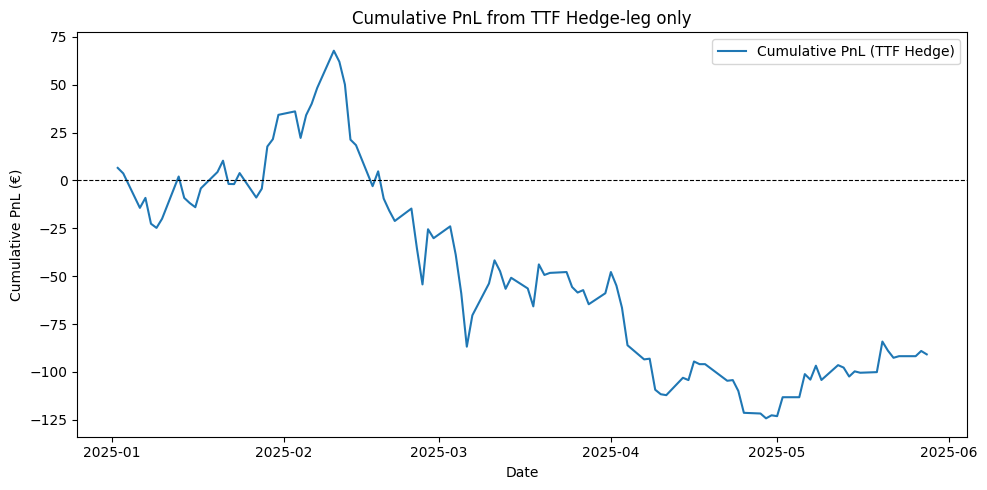

In [79]:
# Assume gas_daily_mwh = 8.0 (MWh per day), as before.
gas_daily_mwh = 8.0

# 1) Compute the daily hedge quantity (MWh) by multiplying your daily burn by the hedge ratio.
hedging_results["HedgeQty_TTF"] = gas_daily_mwh * hedging_results["Hedge_Ratio_TTF"]

# 2) Compute daily PnL: (ΔPrice) * (hedged quantity).
hedging_results["PnL_TTF"] = price_ttf.diff().loc[hedging_results.index] * hedging_results["HedgeQty_TTF"]

# 3) Compute the cumulative PnL.
hedging_results["CumPnL_TTF"] = hedging_results["PnL_TTF"].cumsum()

# 4) Now plot the cumulative PnL as a line.
plt.figure(figsize=(10, 5))
plt.plot(hedging_results.index, hedging_results["CumPnL_TTF"], label="Cumulative PnL (TTF Hedge)", color="tab:blue")
plt.axhline(0, color="black", linewidth=0.8, linestyle="--")  # zero‐line for reference
plt.title("Cumulative PnL from TTF Hedge-leg only")
plt.ylabel("Cumulative PnL (€)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Write a CSV of hedging results 
hedging_results.to_excel("hedging_results.xlsx", index=True)